In [7]:
import pandas_datareader as pdr
import subprocess
import pandas as pd 
import numpy as np
from jinja2 import Environment, FileSystemLoader
from pandas.plotting import scatter_matrix
%matplotlib inline
import math
from sklearn import preprocessing
import datetime
# from weasyprint import HTML

In [8]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2017, 1, 11)
df = pdr.get_data_yahoo('AAPL', start_date, end_date)

In [9]:
# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.head()

Date
2010-01-04   NaN
2010-01-05   NaN
2010-01-06   NaN
2010-01-07   NaN
2010-01-08   NaN
Name: Adj Close, dtype: float64

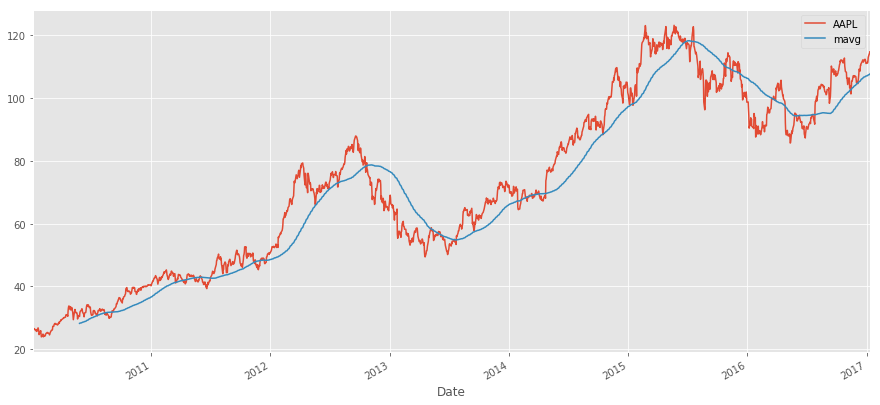

In [10]:
# Rolling mean average
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(15, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

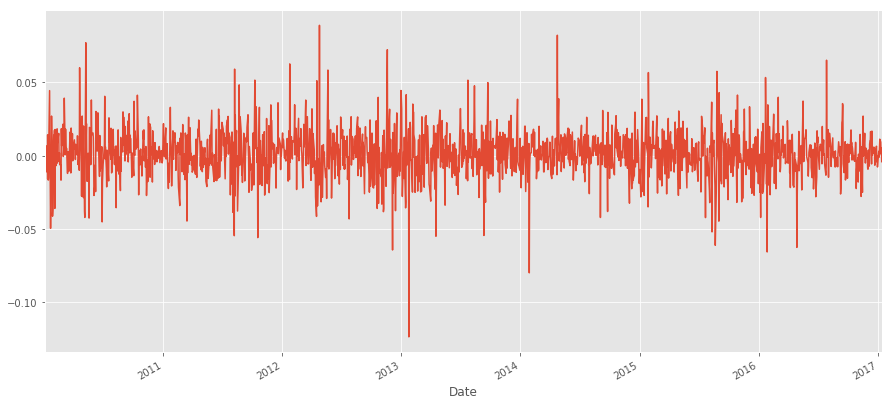

In [11]:
# Risk and return
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [12]:
# Competitor stocks
dfcomp = pdr.get_data_yahoo(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],start_date,end_date)['Adj Close']

In [13]:
# Correlation analysis
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

Text(0, 0.5, 'Returns GE')

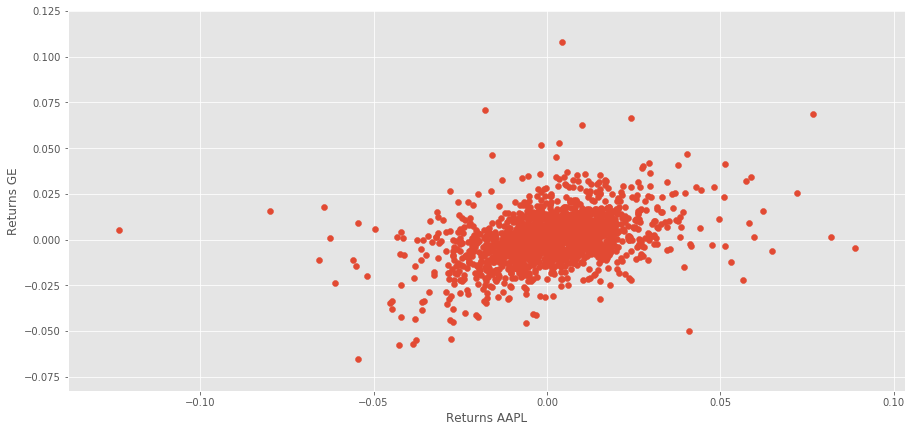

In [14]:
# Viewing distributions
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

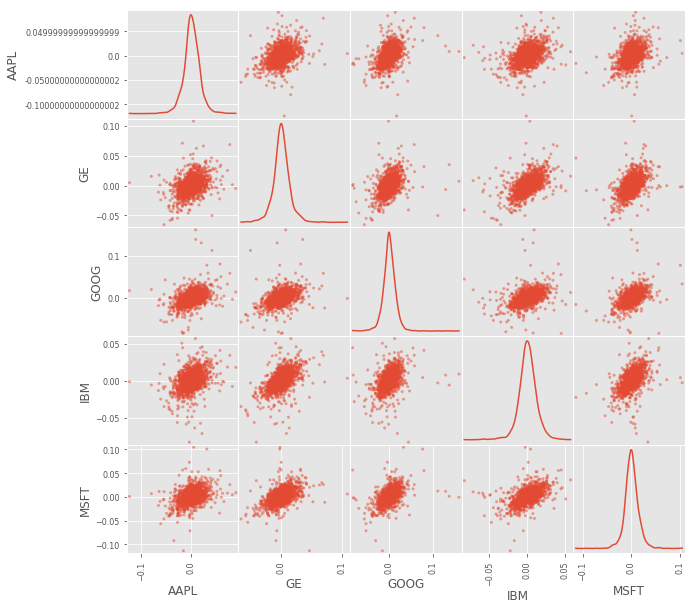

In [15]:
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

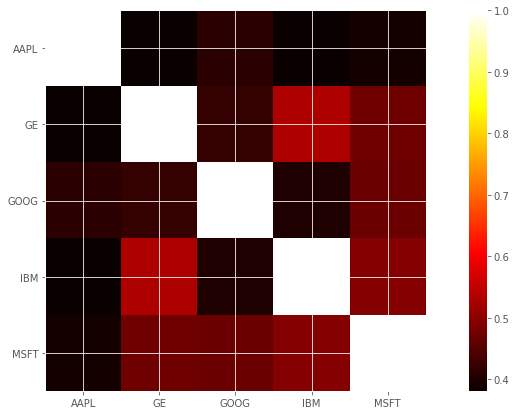

In [16]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

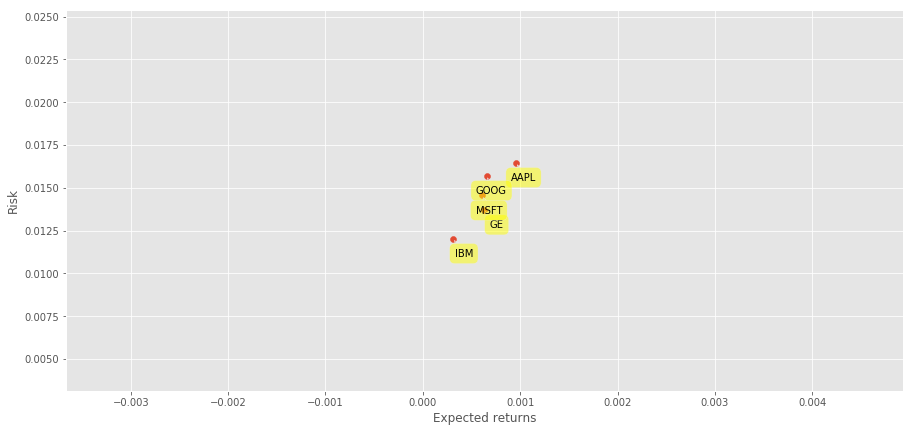

In [17]:
# Risk and return comparison
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [18]:
#Prediciting stocks
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-04,26.681330,123432400.0,0.990606,0.271752
2010-01-05,26.727465,150476200.0,1.091520,-0.102519
2010-01-06,26.302330,138040000.0,2.123523,-1.590633
2010-01-07,26.253704,119282800.0,1.400893,-0.552538
2010-01-08,26.428249,111902700.0,1.386924,0.798864


In [19]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

C:\Users\Roland.Ferrao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [21]:
# Linear regression
# clfreg = LinearRegression(n_jobs=-1)
# clfreg.fit(X_train, y_train)

# Quadratic Regression 2
# clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
# clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
# clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
# clfpoly3.fit(X_train, y_train)

# How to find X_train?

In [22]:
# Portfolio returns
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2017, 1, 11)
port_df = pdr.get_data_yahoo(['AAPL', 'GOOG', 'GS', 'AMZN'], start_date, end_date)['Adj Close']

In [23]:
daily_simple_returns = port_df.pct_change()
daily_simple_returns.head()

Symbols,AAPL,AMZN,GOOG,GS
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.005900,-0.004404,0.017679
2010-01-06,-0.015906,-0.018116,-0.025209,-0.010673
2010-01-07,-0.001849,-0.017013,-0.023280,0.019568
2010-01-08,0.006648,0.027077,0.013331,-0.018911


In [24]:
# annualise daily returns. 250 trading days in a year
annual_returns = daily_simple_returns.mean() * 250
annual_returns

Symbols
AAPL    0.239586
AMZN    0.306731
GOOG    0.164643
GS      0.098253
dtype: float64

In [25]:
# number of assets in the randomly selected portfolio
num_assets = 4
weights = np.random.random(num_assets)
weights = weights / sum(weights)
weights

array([0.56557052, 0.28075317, 0.03715212, 0.11652419])

In [26]:
sum(weights)

1.0000000000000002

In [27]:
# calculate expected returns of the portfolio 
port_returns_expected = np.sum(weights * annual_returns)
port_returns_expected

0.23918424668725782

In [28]:
# convert the float into a percentage cos why not ;)
print(str(round(port_returns_expected * 100, 2)) + '%')

23.92%


In [29]:
# Testing 

In [36]:
# Portfolio returns
# DJIA, SPY, INDEXSP, 
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2018, 1, 11)
port_df = pdr.get_data_yahoo(['SPY', 'AAPL', 'MSFT', 'NVDA', 'GS'], start_date, end_date)['Adj Close']

In [37]:
port_df.head()

Symbols,AAPL,GS,MSFT,NVDA,SPY
Date,,,,,
2018-01-02,167.701889,248.495102,83.539680,198.168060,260.130951
2018-01-03,167.672668,246.181885,83.928474,211.210266,261.776276
2018-01-04,168.451508,249.622543,84.667145,212.323624,262.879608
2018-01-05,170.369385,248.349289,85.716881,214.122879,264.631439
2018-01-08,169.736588,244.743439,85.804337,220.683762,265.115387


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A55071A7F0>,
      dtype=object)

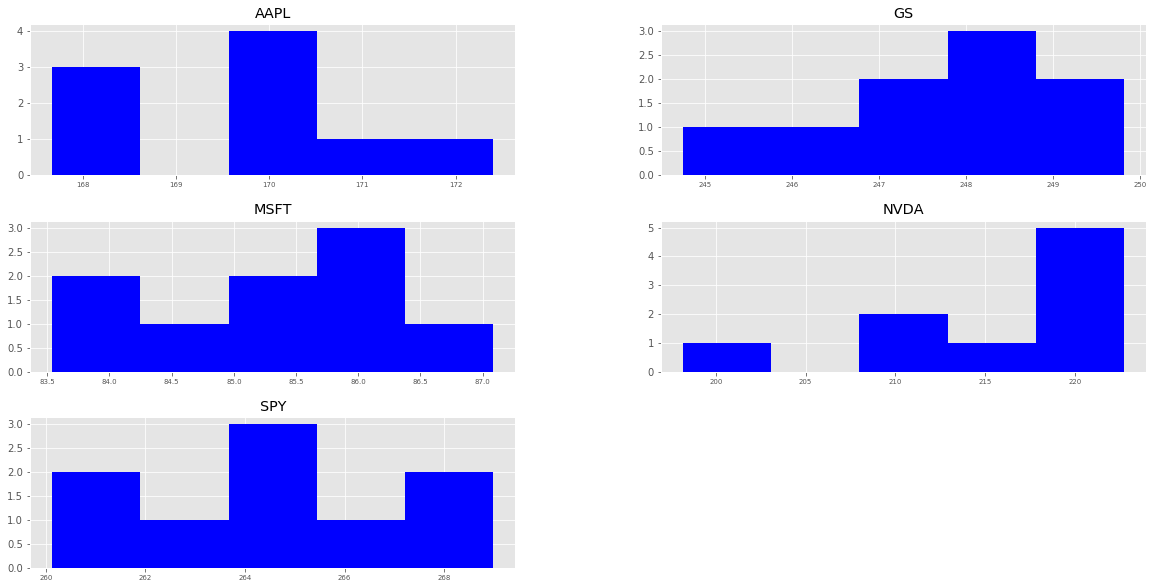

In [56]:
port_df.hist(color = 'blue', xlabelsize = 7, figsize = (20, 10), bins = 5)

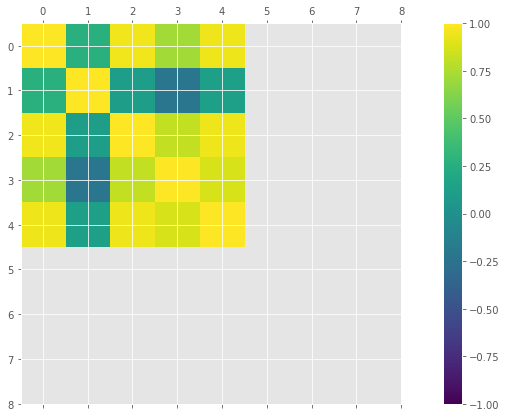

In [59]:
correlations = port_df.corr(method = 'pearson')
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

In [61]:
port_df.corr(method = 'pearson')

Symbols,AAPL,GS,MSFT,NVDA,SPY
Symbols,,,,,
AAPL,1.000000,0.272460,0.960042,0.724233,0.951786
GS,0.272460,1.000000,0.119523,-0.214081,0.128780
MSFT,0.960042,0.119523,1.000000,0.813201,0.951589
NVDA,0.724233,-0.214081,0.813201,1.000000,0.880170
SPY,0.951786,0.128780,0.951589,0.880170,1.000000


In [62]:
daily_returns_df = port_df.pct_change()

In [63]:
daily_returns_df.head()

Symbols,AAPL,GS,MSFT,NVDA,SPY
Date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.000174,-0.009309,0.004654,0.065814,0.006325
2018-01-04,0.004645,0.013976,0.008801,0.005271,0.004215
2018-01-05,0.011385,-0.005101,0.012398,0.008474,0.006664
2018-01-08,-0.003714,-0.014519,0.001020,0.030641,0.001829


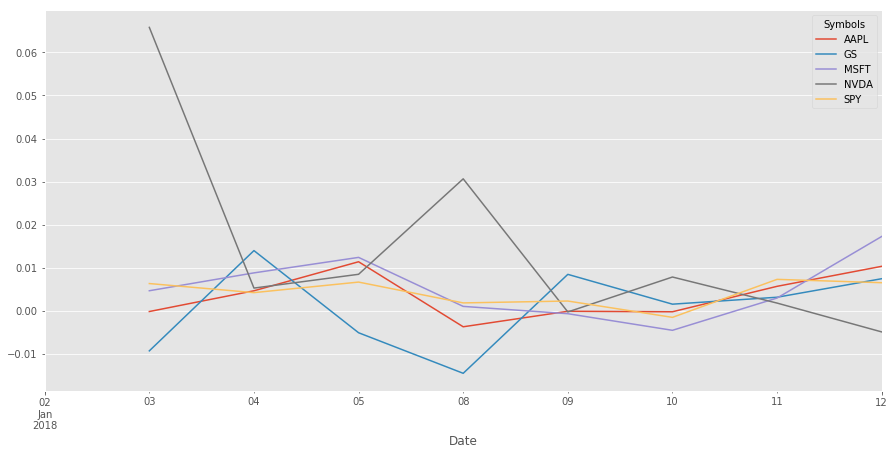

In [64]:
daily_returns_df.plot()

In [65]:
cum_daily_returns_df = (1+ daily_returns_df).cumprod()

In [66]:
cum_daily_returns_df.head()

Symbols,AAPL,GS,MSFT,NVDA,SPY
Date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.999826,0.990691,1.004654,1.065814,1.006325
2018-01-04,1.004470,1.004537,1.013496,1.071432,1.010566
2018-01-05,1.015906,0.999413,1.026062,1.080512,1.017301
2018-01-08,1.012133,0.984902,1.027109,1.113619,1.019161


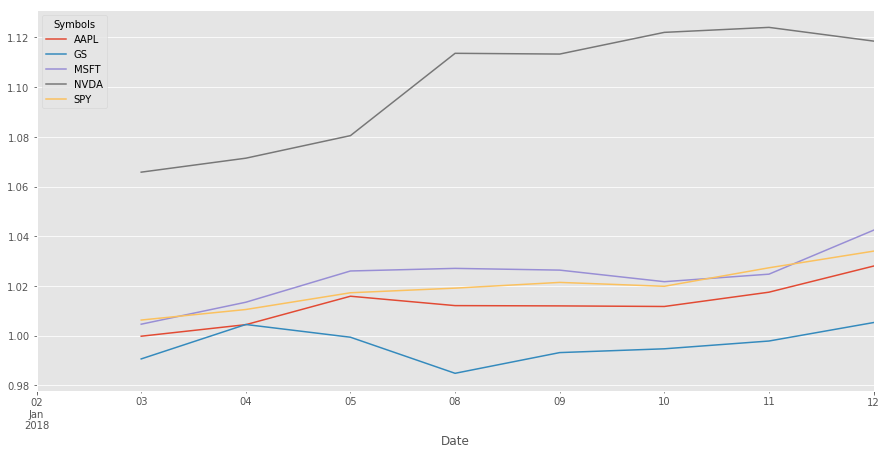

In [67]:
cum_daily_returns_df.plot()